In [1]:
import ipywidgets as ipw
from ipywidgets import interact, FloatLogSlider, IntSlider, interact_manual, interactive, interactive_output, fixed
%matplotlib inline

In [2]:
# Hacky but for now..
import sys
sys.path.append('../')
from lightning_trainer import LitModelTrainer
from generate_dreams.render_engine import generate_dream

In [3]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

import numpy as np

import json

import torch
from torch.utils.data import DataLoader

import PIL
from PIL import GifImagePlugin, Image, ImageDraw, ImageFont

import torchvision
from torchvision.datasets import CIFAR10, MNIST
from torchvision import transforms





In [4]:

torch_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
models = {}
use_dataset:str = "CIFAR"
# use_dataset:str = "MNIST"
# 
_model_loc_list_cifar = {
    "basemodel": '../trained_models/CIFAR/base/version_0/checkpoints/model.ckpt',

}

_model_loc_list_mnist = {

}

if "MNIST" in use_dataset:
    _model_loc_list = _model_loc_list_mnist
else:
    _model_loc_list = _model_loc_list_cifar

for _modelname, _modelloc in _model_loc_list.items():
    _cpth = LitModelTrainer.load_from_checkpoint(_modelloc)
    _model = _cpth.model
    _model.eval()
    models[_modelname] = _model


dev = False # For dev purposes - Does not execute long exec.time cells if not developing them
# save_data = True
save_data = False
save_loc = 'imgs/test'
save_suffix = '_test'

c:\Users\stefa\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [5]:
_transforms = transforms.Compose([transforms.ToTensor(),])
_to_pil = transforms.ToPILImage()

_CIFAR_data = CIFAR10(root='../../../data/cifar/', train=True, download=True, transform=_transforms)
cifar_dataloader = DataLoader(dataset=_CIFAR_data, batch_size=128, shuffle=False, num_workers=0)


_MNIST_data = MNIST(root='../../../data/mnist/', train=True, download=True, transform=_transforms)
mnist_dataloader = DataLoader(dataset=_MNIST_data, batch_size=128, shuffle=False, num_workers=0)

if "MNIST" in use_dataset:
    dataloader = mnist_dataloader
else:
    dataloader = cifar_dataloader



Files already downloaded and verified


100%|██████████| 9912422/9912422 [00:00<00:00, 79805497.21it/s]


Extracting ../../../data/mnist/MNIST\raw\train-images-idx3-ubyte.gz to ../../../data/mnist/MNIST\raw



100%|██████████| 28881/28881 [00:00<?, ?it/s]


Extracting ../../../data/mnist/MNIST\raw\train-labels-idx1-ubyte.gz to ../../../data/mnist/MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 33289970.00it/s]


Extracting ../../../data/mnist/MNIST\raw\t10k-images-idx3-ubyte.gz to ../../../data/mnist/MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting ../../../data/mnist/MNIST\raw\t10k-labels-idx1-ubyte.gz to ../../../data/mnist/MNIST\raw



In [6]:
img_b = next(iter(dataloader))
_x, _y = img_b

_unique, _inverse = torch.unique(_y, return_inverse=True, dim=0)

_perm = torch.arange(_inverse.size(0), dtype=_inverse.dtype, device=_inverse.device)

_inverse, _perm = _inverse.flip([0]), _perm.flip([0])

_first_class_idxs = _inverse.new_empty(_unique.size(0)).scatter_(0, _inverse, _perm)

In [7]:
_dream_imgs = _x[_first_class_idxs]
_dream_lbl = torch.arange(0, 10, 1, device=torch_device)

img_b = (_dream_imgs, _dream_lbl)

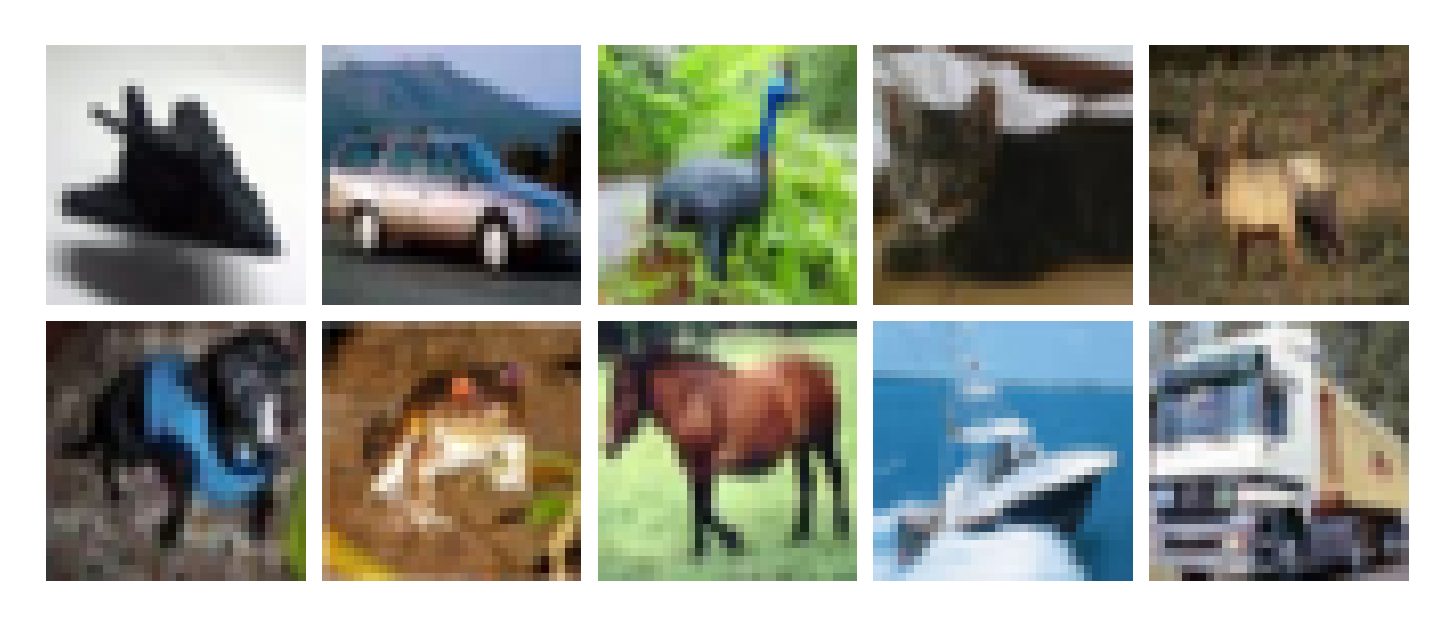

In [8]:
_x, _y = img_b

_first_img = torchvision.utils.make_grid(_x, padding=2, nrow=5, pad_value=1).detach().cpu()
_first_img = _to_pil(_first_img)

axes = plt.imshow(_first_img, interpolation=None)
plt.tick_params(
    axis='both',
    which='both',
    bottom=False,
    top=False,
    labelleft=False,
    labelbottom=False,
    left=False)
for pos in ['right', 'top', 'bottom', 'left']:
    plt.gca().spines[pos].set_visible(False)
plt.savefig(f'imgs/{use_dataset}_first_imgs.pdf')
plt.show()

In [9]:
# boatimg = _x[5]
# boatimg = _to_pil(boatimg)
# with open("imgs/5.jpeg", 'wb') as f:
#     boatimg.save(fp=f , format="jpeg", quality=100)

In [10]:
# if save_gif:
#     pil_img_array[0].save(gif_save_loc + 'lr1e3_smooth_cat_pgd5.gif', format='GIF',
#         append_images=pil_img_array[1:],
#         duration=50,
#         interlace=False,
#         save_all=True,
#         loop=0)

In [11]:
def calculate_lpdist(im1:torch.Tensor, im2:torch.Tensor, ord=2):
    diff = torch.sub(im1, im2)
    return torch.linalg.vector_norm(diff, ord=ord, dim=(-3, -2, -1))


In [12]:
class control_params():
    def __init__(self, architecture='CIFAR'):

        if architecture == 'CIFAR':
            self._iter_step = 1
            self._max_iter = 512
            self._iter_list = np.arange(0, self._max_iter + self._iter_step, self._iter_step)

            self._lrstart = -4
            self._lrstop = -1
            self._lr_list = np.logspace(base=10, start=self._lrstart, stop=self._lrstop, num=self._lrstop - self._lrstart + 1)

            self._lr_slider = FloatLogSlider(value=(10**self._lrstart), base=10, min=self._lrstart, max=self._lrstop, step=1, description="LR", readout_format=".4f")

            self._l2_start = 0
            self._l2_stop = 0
            self._l2_step = 5
            self._l2_weight_list = np.arange(start=self._l2_start, stop=self._l2_start + self._l2_stop +1, step=self._l2_step)
            self._l2_slider = IntSlider(min=self._l2_start, max=self._l2_stop, step=self._l2_step, value=self._l2_start)

            
        elif architecture == 'MNIST':
            self._iter_step = 1
            self._max_iter = 256
            self._iter_list = np.arange(0, self._max_iter + self._iter_step, self._iter_step)

            self._lrstart = -3
            self._lrstop = -1
            self._lr_list = np.logspace(base=10, start=self._lrstart, stop=self._lrstop, num=self._lrstop - self._lrstart + 1)
            self._lr_slider = FloatLogSlider(value=(10**self._lrstart), base=10, min=self._lrstart, max=self._lrstop, step=1, description="LR", readout_format=".4f")

            self._l2_start = 0
            self._l2_stop = 0
            self._l2_step = 25
            self._l2_weight_list = np.arange(start=self._l2_start, stop=self._l2_start + self._l2_stop + 1, step=self._l2_step)
            self._l2_slider = IntSlider(min=self._l2_start, max=self._l2_stop, step=self._l2_step, value=self._l2_start)


In [18]:
def interactive_dreams(model, **dream_params):

    cp = control_params(use_dataset)

    hparam_dict = {"lr_list": cp._lr_list.tolist(), "iter_list": cp._iter_list.tolist(), "l2_weight_list": cp._l2_weight_list.tolist(), **dream_params}

    dreams = {}
    raw_dreams = {}
    logit_diffs = {}

    for _lr_value in cp._lr_list:
        dreams[_lr_value] = {}
        raw_dreams[_lr_value] = {}
        logit_diffs[_lr_value] = {}

        _l2_w_value = 0
        dreams[_lr_value][_l2_w_value] = []
        raw_dreams[_lr_value][_l2_w_value] = []
        logit_diffs[_lr_value][_l2_w_value] = []

        _dream_img_tensor = generate_dream(model=model,
            batch=img_b,
            device=torch_device,
            opt_lr=_lr_value,
            iterations=cp._iter_list,
            **dream_params
            )
        for i in range(len(cp._iter_list)):
            # _dream_tens = torch.cat((_dream_img_tensor[i], _dream_img_tensor_test[i]), dim=0)
            _dream_tens = _dream_img_tensor[i]
            _grid_img = torchvision.utils.make_grid(_dream_tens, padding=2, nrow=10, pad_value=1).detach().cpu()
            _pil_img = _to_pil(_grid_img)
            dreams[_lr_value][0].append(_pil_img)
            raw_dreams[_lr_value][0].append(_dream_tens)
                


    def show_gif():

        def view_img(i, lr):
            # if ax_data:
            #     ax_data.set_data(dreams[lr][l2_weight][i//_iter_step])
            # else:
            #     ax_data = ax.imshow(dreams[lr][l2_weight][i//_iter_step], interpolation=None)

            fig, ax = plt.subplots(figsize = (12, 4))
            ax.imshow(dreams[lr][0][i//cp._iter_step], interpolation=None)
            plt.tick_params(
                axis='both',
                which='both',
                bottom=False,
                top=False,
                labelleft=False,
                labelbottom=False,
                left=False)
            for pos in ['right', 'top', 'bottom', 'left']:
                plt.gca().spines[pos].set_visible(False)
            plt.show()
            
            dists = calculate_lpdist(raw_dreams[lr][0][i//cp._iter_step], raw_dreams[lr][0][0], ord=2).tolist()
            print(f'\n L2 distance to original:\n {["{0:0.2f}".format(val) for val in dists]}')
            print(f'\n Mean distance of this set: {np.mean(dists):.4f}')

        interact(view_img, i=(0, cp._iter_list[-1], cp._iter_step), lr=cp._lr_slider)


    return show_gif(), dreams, hparam_dict

In [19]:
def append_images(images, direction='horizontal',
                  bg_color=(255,255,255), aligment='center', padding=4):
    """
    Appends images in horizontal/vertical direction.

    Args:
        images: List of PIL images
        direction: direction of concatenation, 'horizontal' or 'vertical'
        bg_color: Background color (default: white)
        aligment: alignment mode if images need padding;
           'left', 'right', 'top', 'bottom', or 'center'

    Returns:
        Concatenated image as a new PIL image object.
    """
    widths, heights = zip(*(i.size for i in images))

    
    if direction=='horizontal':
        new_width = sum(widths) + (len(images) * padding)
        new_height = max(heights) + (2 * padding)
    else:
        new_width = max(widths)
        new_height = sum(heights) 

    new_im = Image.new('RGB', (new_width, new_height), color=bg_color)


    offset = 0
    for im in images:
        if direction=='horizontal':
            y = 0
            if aligment == 'center':
                y = int((new_height - im.size[1])/2)
            elif aligment == 'bottom':
                y = new_height - im.size[1]
            new_im.paste(im, (offset, y))
            offset += im.size[0] + padding
        else:
            x = 0
            if aligment == 'center':
                x = int((new_width - im.size[0])/2)
            elif aligment == 'right':
                x = new_width - im.size[0]
            new_im.paste(im, (x, offset))
            offset += im.size[1] + padding

    return new_im

In [22]:
def create_iteration_legend(slice_step:int = 1, direction='vertical'):
    width, height = 32, 28
    # width, height = 32, 32
    img_l = []
    for i in range(9):
        img = Image.new('RGB', (width, height), color=(255,255,255))
        # if i != 0:
        #     fnt = ImageFont.truetype('Arial.ttf', 13)
        #     draw_img = ImageDraw.Draw(img)
        #     draw_img.text(xy = (4, 8), text=str(i * slice_step), fill=(0,0,0), font=fnt)
        img_l.append(img)
    return append_images(img_l, direction=direction)

In [23]:
if not dev:

    # _x, _y = _x[5].unsqueeze(0), _y[5].unsqueeze(0)
    # img_b = _x, _y


    _steps_dict = {
        'MNIST': {
            0.001: 64,
            0.01: 32,
            0.1: 16,
            1.0: 2
        }, 
        'CIFAR': {
            0.0001: 64,
            # 0.001: 64,
            0.01: 16,
            0.1: 4,
            1.0: 1
        }
    }


    # print("This likely is slow. You have been warned ;)")

    dream_kwarg = {
                    # "use_parametrization":"linear", bound_hyperbolic,
                    # "linf_limit": 0.2,
                    # "penal_f":"bound_hyperbolic",
                    # penal_factor,
                    # limit_eps = 1.0
                    "parametrization":"tanh",
                    
                    }
    dreams_to_save = {}
    
    for _identifier, _model in models.items():
        print(f"Dreams for model {_identifier}")
        print(f"params: {dream_kwarg}")
        
        interactive_d, dreams, hparam_dict = interactive_dreams(_model, **dream_kwarg)


        im = {}
        for lr_ in dreams:
            if lr_ in _steps_dict[use_dataset]:
                _step = _steps_dict[use_dataset][lr_]
            else:
                _step = len(dreams[lr_][0]) // 8
            
            print(f"step: {_step} for lr {lr_}")

            # _dreams =  append_images(dreams[lr_][0][:(8*_step)+1:_step], direction='vertical')
            # im[lr_] = append_images([create_iteration_legend(_step), _dreams], direction='horizontal')

            _dreams =  append_images(dreams[lr_][0][:(8*_step)+1:_step], direction='horizontal', padding=8)
            im[lr_] = append_images([create_iteration_legend(_step, 'horizontal'), _dreams], direction='vertical', padding=2)

        for _, dream_stacked in im.items():
            dreams_to_save[f"{save_loc}/{use_dataset}_{_identifier}_lr{_}_5"] = dream_stacked
            
            
        # if save_data:
        #     _save_name = save_loc +_identifier.replace(" ", "_")+ "_" +save_suffix
        #     torch.save(dreams, _save_name + '.pkl')
        #     with open((_save_name + ".json"), 'w') as f:
        #         json.dump(hparam_dict, f, indent=4)
        


Dreams for model basemodel
params: {'parametrization': 'tanh'}


interactive(children=(IntSlider(value=256, description='i', max=512), FloatLogSlider(value=0.0001, description…

step: 64 for lr 0.0001
step: 64 for lr 0.001
step: 16 for lr 0.01
step: 4 for lr 0.1


In [24]:

if save_data:
    for name, dream_img in dreams_to_save.items():
        with open(name + ".jpeg", 'wb') as f:
            # dream_img.save(fp=f , format="bmp", resolution=50)
            dream_img.save(fp=f , format="jpeg", quality=100)


# display(dreams[0.01][0][8])